# Text Generation

<center><h3>Spooky Author Identification-Kaggle</h3></center>
 <center><h3> https://www.kaggle.com/c/spooky-author-identification</h3></center>

Here, I try to generate new sentences after training an RNN on around 20,000 sentences taken from the Kaggle dataset above. While the dataset was originally meant for a different purpose, I couldn't find a dedicated dataset for text generation, so I decided to use this one.




## Idea

I will be using language modeling to generate text. In its essence, language modeling tries to predict the next word, given prior words.  For example, given the word ''Ryan loves cats" , language model tries to find P((next word)| 'Ryan') and then P((next word)|'Ryan', 'loves'). Ideally, the model must learn that next word is 'loves' and 'cats' for the two cases
mentioned above.

In the first part, I develop a basic word based rnn model from scratch, that works on the idea mentioned above. This model serves the show the various preprocessing steps required to feed the data and get predictions, it does not have a very good performance. In the final step, I take a pretrained char - level rnn, train it for a few epochs and use that to generate much better predictions.

## Steps

1. First I will preprocess the input text by tokenizing the text, generating a vocabulary of unique words from it, and saving that vocabulary in the file 'vocab.txt'.
2. Then I will add three extra tokens - START denoting the start of a sentence, UNK for unknown words and PAD for pad tokens.
3. Since I have limited computational power, I will restrict myself to generating sentences of maximum 20 words. This decision was made after observing the frequency of different sentence lengths in the database. All sentences greater than 20 words will be truncated, and shorter sentences will have PAD  tokens till they reach the length 20.
4. Before feeding into the RNN, the words will be numerized by using a mapping of words in vocab.txt to corresponding numbers.
5. For text generation, we first prepend the START token to each sentence, shifting it to the right by 1 sentence. That will be used as input to predict the output sentence. For example - For the sentence ' (START) Do it', '(START)' will be used to predict 'Do', '(START), Do' will be used to predict 'it' and so on. 
6. The data will be fed to the network in the form of batches, and LSTM Cell will be used to learn the next word by minimising the cross-entropy softmax function.
7. For generating new text, I will enter the first few words. Then the trained model will keep on picking the next most likely word ( given by the argmax) and generate the sentence.


In [0]:
!pip install segtok # needed for tokenization

     |████████████████████████████████| 655kB 7.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built segtok regex


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from segtok import tokenizer
import tensorflow as tf
import numpy as np
import json
import os, sys

sys.path.insert(0, "/content/gdrive/My Drive/text_generation/") 

root_folder = "/content/gdrive/My Drive/text_generation/"

## Preprocessing

The function 'unique_file' opens the input file ('train.txt'), reads it and saves all the unique words in an output file ('vocab.txt'). We also store the word lengths in a dictionary, where key is the word length and value is the number of sentences having that length. We then plot a word length distribution.

In [0]:
def unique_file(input_filename, output_filename):
    input_file = open(input_filename, 'r')
    file_contents = input_file.read()
    input_file.close()
    duplicates = set()
    word_list = file_contents.split()
    file = open(output_filename, 'w')
    for word in word_list:
        if word.lower() not in duplicates:
            duplicates.add(word.lower())
            file.write(str(word.lower()) + "\n")
    file.close()

In [0]:
from collections import defaultdict
wordcounts = defaultdict(int)
d = dict()
with open(root_folder+"train.txt") as f:
    text = f.read()
    sentences = text.split('.')
    for sentence in sentences:
        words = sentence.split(' ')
        wordcounts[len(words)] += 1

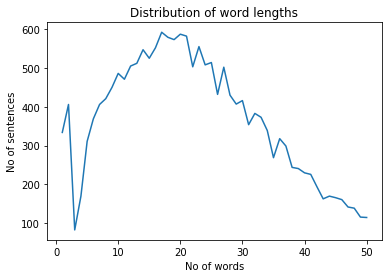

In [0]:

import matplotlib.pyplot as plt

lists = sorted(wordcounts.items())[:50] # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Distribution of word lengths")
plt.xlabel("No of words")
plt.ylabel("No of sentences")
plt.plot(x, y)

plt.show()

In [0]:
unique_file(root_folder+"train.txt", root_folder+"vocab.txt")

'numerize_sequence' converts each word to its corresponding mapping to a number. 'pad_sequence' adds pad tokens to a sentence till  it is of the length 'to_length' (in this case, 20)

In [0]:
def numerize_sequence(tokenized):
    return [w2i.get(w, unkI) for w in tokenized]
def pad_sequence(numerized, pad_index, to_length):
    pad = numerized[:to_length]
    padded = pad + [pad_index] * (to_length - len(pad))
    mask = [w != pad_index for w in padded]
    return padded, mask

I have manually added 3 tokens 'UNK', 'PAD', 'START' to vocab.txt file

In [0]:
file = root_folder + "vocab.txt"
with open(file) as f:
    vocabulary = f.read().split()

In [0]:
w2i = {w: i for i, w in enumerate(vocabulary)}
input_length = 20
unkI, padI, start_index = w2i['UNK'], w2i['PAD'], w2i['<START>']


Now, I break each sentence into the dataset into following 4 parts:
- title - The actual text
- numerized - Numerized version of the text
- mask - Gives information about how long each sentence is
- part - Whether the sentence is part of training or validation (every 10th sentence is put into validation set)

In [0]:
data = []
i = 0
input_length = 20
with open(root_folder+"train.txt") as f:
    text = f.read()
    sentences = text.split('.')
    for sentence in sentences:
      data.append(dict())
      sentence = sentence.replace('\n', '')
      words = sentence.split(' ')
      l = min(len(words), input_length) 
      sentence = ''
      for i in range(1, l): 
        sentence = sentence+words[i] + ' ' # LSTM is trained on lower-cased headlines
      data[-1]["title"] = sentence

      # Tokenize the sentence
      tokenized = tokenizer.word_tokenizer(sentence)

      # numerize the tokenized headline
      numerized = numerize_sequence(tokenized)
      padI = w2i['PAD']
      numerized, mask = pad_sequence(numerized, padI, input_length) # Append appropriate PAD tokens

      data[-1]['numerized'] = numerized

      # apply mask
      data[-1]['mask'] = mask

      # split into train and test
      if i%10:
        data[-1]['part'] = "train"
      else:
        data[-1]['part'] = "validation"
      i += 1

In [0]:
data[1]

{'mask': [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False],
 'numerized': [39,
  40,
  41,
  24,
  7,
  42,
  12,
  43,
  18,
  44,
  45,
  46,
  21003,
  2,
  2,
  2,
  2,
  2,
  2,
  2],
 'part': 'train',
 'title': 'never once occurred to me that the fumbling might be a mere mistake '}

In [0]:
d_train = [d for d in data if d['part'] == 'train']
d_valid = [d for d in data if d['part'] == 'validation']

print("Number of training samples:",len(d_train))
print("Number of validation samples:",len(d_valid))

Number of training samples: 19512
Number of validation samples: 564


## Making pipeline to feed batches of sentences into the neural net

In [0]:
def build_batch(dataset, batch_size):

    # choose random indices for each batch
    indices = list(np.random.randint(0, len(dataset), size=batch_size))
    
    # Recover what the entries for the batch are
    batch = [dataset[i] for i in indices]
    
    # Get numerized for this input, each element of the dataset has a 'numerized' key
    batch_numerized = [i['numerized'] for i in batch]

    # Create an array of start_indices that will be concatenated at beginning of input
    start_tokens = np.array([start_index]*batch_size).reshape((batch_size, 1))

    # Concatenate the start_tokens with the rest of the input
    batch_input = np.concatenate((start_tokens, batch_numerized), axis=1) 

    # Remove the last word from each element in the batch
    batch_input = batch_input[:,:-1]
    #print(batch_input.shape)
    
    batch_target = batch_numerized

    # The target-mask to know which places have 'PAD' token
    batch_target_mask = np.array([a['mask'] for a in batch])
       
    return batch_input, batch_target, batch_target_mask

# RNN


- I will use placeholders to feed in inputs and actual targets.
- Then I will use an RNN to get an output, and project it on the dimension of size 'vocabulary' so that we get probability estimates for each word in the vocabulary.
- The optimizer will try to minimize the loss between the predicted word and the actual word.

In [0]:
class LanguageModel():
    def __init__(self, input_length, vocab_size, rnn_size, learning_rate=1e-3):
        
        # Creating placeholders
        self.input_num = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets = tf.placeholder(tf.int32, shape=[None, input_length])
        self.targets_mask = tf.placeholder(tf.int32, shape=[None, input_length])

        # Mapping each word in vocab into a vector of rnn_size size.
        embedding = tf.get_variable("embedding", [vocab_size, rnn_size], dtype = tf.float32)
        input_emb = tf.nn.embedding_lookup(embedding, self.input_num)
        
        # Create the RNN (I use LSTM with Dropout after trying some other combinations)   
        lm_cell = tf.nn.rnn_cell.LSTMCell(rnn_size)
        lm_cell = tf.nn.rnn_cell.DropoutWrapper(lm_cell, input_keep_prob = 0.8)
        # dynamic_rnn introduces the recurrence
        outputs, states = tf.nn.dynamic_rnn(lm_cell, input_emb, dtype = tf.float32)

        # Project rnn output to vocab_size
        self.output_logits = tf.layers.dense(outputs,units = vocab_size ) 

        # calculate loss
        self.loss = tf.losses.sparse_softmax_cross_entropy(labels = self.targets, logits = self.output_logits, weights = self.targets_mask)                 

        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)       

        self.global_step = tf.train.get_or_create_global_step()
        self.train_op = optimizer.minimize(self.loss, global_step = self.global_step)
        self.saver = tf.train.Saver()

In [0]:
tf.reset_default_graph()# clear variable space
vocab_size = len(vocabulary)
model = LanguageModel(input_length=input_length, vocab_size=vocab_size, rnn_size=256, learning_rate=1e-3)

W0627 07:26:46.582612 140158910969728 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0627 07:26:46.601772 140158910969728 deprecation.py:323] From <ipython-input-12-efb174729623>:14: LSTMCell.__init__ (from tensorflow.python.ops.rnn_cell_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
W0627 07:26:46.609007 140158910969728 deprecation.py:323] From <ipython-input-12-efb174729623>:17: dynamic_rnn (from tensorflow.python.ops.rnn) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `keras.layers.RNN(cell

## Model Training

I experimented with a range of hyperparameters :
- Learning rate
- Type of optimizer ( Adam, SGD etc)
- Using dropout 
- Architecture - Using rnn cell, LSTM cell.

Finally I train my model for 10000 iterations with a batch size of 16, so roughly 8 epochs  (takes around 20 minutes on my system). 
Final parameters are:
Learning rate of 1e-3, LSTM cell with size of 256 with keep_prob of 0.8, Adam Optimizer

In [0]:
experiment = root_folder+"models/language_model_1"

with tf.Session() as sess:
  
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
      batch_size = 16
      batch_input, batch_target, batch_target_mask = build_batch(d_train, batch_size)
      feed = {model.input_num: batch_input, model.targets: batch_target, model.targets_mask: batch_target_mask}

      step, train_loss, _ = sess.run([model.global_step, model.loss, model.train_op], feed_dict=feed)
      if i%2000 == 0: 
        print(f"Loss after {i} iterations: ", train_loss)
    
    model.saver.save(sess, experiment)

Loss after 0 iterations:  10.769726
Loss after 2000 iterations:  5.676057
Loss after 4000 iterations:  5.030911
Loss after 6000 iterations:  5.150795
Loss after 8000 iterations:  4.4185038


## Checking loss on validation set

In [0]:
model_file = root_folder+"models/language_model_1"
with tf.Session() as sess:
    model.saver.restore(sess, model_file)
    eval_input, eval_target, eval_target_mask = build_batch(d_valid, 500)
    feed = {model.input_num: eval_input, model.targets: eval_target, model.targets_mask: eval_target_mask}
    eval_loss = sess.run([model.loss], feed_dict=feed)
    print("Evaluation set loss:", eval_loss)

W0627 07:54:23.348746 140158910969728 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Evaluation set loss: [6.521181]


## Text Generation

For generating new text, I will enter the first few words. Then the trained model will keep on picking the next most likely word ( given by the argmax) and generate the sentence.

In [0]:
with tf.Session() as sess:
    model.saver.restore(sess, model_file)
    headline_starters = ["i even ", "all that", "where was", "sometimes it"]
    input_length = 20
    for headline_starter in headline_starters:
        print("===================")
        print("Generating headline starting with: "+headline_starter)

        tokenized = tokenizer.word_tokenizer(headline_starter)
        current_build = [start_index] + numerize_sequence(tokenized)

        while len(current_build) < input_length:
            # Pad so that sentence can be fed in the rnn
            current_padded = current_build[:input_length] + [padI] * (input_length - len(current_build))
            current_padded = np.array([current_padded])

            # Obtain the logits for the current padded sequence
            feed = {model.input_num: current_padded}
            logits = np.array(sess.run(model.output_logits, feed_dict=feed))
            
            # Get logits for the last non-pad inputs
            last_logits = logits[0, len(current_build), :]
            
            # Find the highest scoring word in the last_logits, excluding punctuation signs for now as the model hasnt yet learnt how to incorporate them
            word_idx = np.argsort(last_logits)[-10:]
            words = [vocabulary[w] for w in word_idx]
            for idx in word_idx[::-1]:
              if vocabulary[idx] not in ["UNK", "PAD", "<START>", "'", "-","(", ")", ",", "?"]: 
                current_build.append(idx)
                break
        
        # use vocabulary to map numbers back to words
        produced_sentence = [vocabulary[idx] for idx in current_build]
        print(' '.join(produced_sentence))
        

Generating headline starting with: i even 
<START> i even were in and a stampede which the of birds in and a fought in a dedicated in
Generating headline starting with: all that
<START> all that have the of Harris in the of causes in the of a themselves in a of black
Generating headline starting with: where was
<START> where was in a of and a time a time in a of effort to the of causes in
Generating headline starting with: sometimes it
<START> sometimes it that the of folks in the of and a packet in the shift in the of and


## Using pretrained network

The model above serves just to demonstrate the working of a simple rnn, it requires substantial work in terms of making a deeper architecture and training for more time to achieve better performance. For demonstration purposes, I will now use a pretrained char-based rnn (https://github.com/minimaxir/textgenrnn) to show how text is generated after training for 3 epochs. Being a char-based rnn, the model makes some spelling mistakes while generating words, but it does a better job at generating longer sentences than our model. Similarly, one can take other pretrained networks like GPT-2 and use them to generate sentences for our task.

In [0]:
from textgenrnn import textgenrnn


Using TensorFlow backend.


In [0]:
root_folder = "/content/gdrive/My Drive/text_generation/"
textgen.train_from_file(root_folder + 'train.txt', num_epochs=3)
textgen.generate()

19,578 texts collected.
Training on 2,937,742 character sequences.
Epoch 1/3
22951/22951 [==============================] - 346s 15ms/step - loss: 1.4213
####################
Temperature: 0.2
####################
I said the secret of the secret of the steps of the shoulder of the countenance and the continual secret of the contagion of the secret of the sun and the character of the start deserves of the shoulder and secret of the soul of the short best the short and contrary of the countenance of the short

I said the press of the streets of the life of the shoulder of the contemple deserted me to the most conscious of the subject of the sound of the secret of the shoulder of the contribuation of the shoulder and the soul of the deserted contrary of the deserted matter and chief and contribuation of 

I say the shoulder of the shoulder of the careful countenance of the streets of the secret of the continual preserves of the being and contagion of the great and descendation of the opino